# Using the MATLAB Engine

## Install MATLAB Engine API for Python

https://nl.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

In the MATLAB Command Window, perform the following procedure.

1. Open the directory containing the Python API engine.
        >> cd (fullfile(matlabroot,'extern','engines','python'))
        
        
2. Install the API.
        >> system('python setup.py install')

## Start and Stop MATLAB Engine for Python

https://nl.mathworks.com/help/matlab/matlab_external/start-the-matlab-engine-for-python.html

### Start MATLAB Engine for Python
- Start Python® at the operating system prompt.
- Import the matlab.engine package into your Python session.
- Start a new MATLAB® process by calling start_matlab. The start_matlab function returns a Python object, eng, which enables you to pass data and call functions executed by MATLAB.

In [ ]:
import matlab.engine
eng = matlab.engine.start_matlab()

### Run Multiple Engines

Start each engine separately. Each engine starts and communicates with its own MATLAB process.

In [ ]:
eng1 = matlab.engine.start_matlab()
eng2 = matlab.engine.start_matlab()

### Stop Engine
Call either the exit or the quit function.

In [ ]:
eng.quit()

If you exit Python with an engine still running, then Python automatically stops the engine and its MATLAB process.

### Start Engine with Startup Options

Start the engine and pass the options as an input argument string to matlab.engine.start_matlab. For example, start MATLAB with the desktop.

In [ ]:
eng = matlab.engine.start_matlab("-desktop")

You can define multiple startup options with a single string. For example, start the desktop and set the numeric display format to short.

In [ ]:
eng = matlab.engine.start_matlab("-desktop -r 'format short'")

You also can start the desktop after you start the engine.

In [ ]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.desktop(nargout=0)

### Start Engine Asynchronously

Start the engine asynchronously. While MATLAB starts, you can enter commands at the Python command line.

In [ ]:
import matlab.engine
future = matlab.engine.start_matlab(background=True)

Create the MATLAB instance so you can perform computations in MATLAB.

In [ ]:
eng = future.result()

## Python data structure into MATLAB

Various methods of bringing data structures into MATLAB from Python exist. [Each have their own pros and cons.](https://stackoverflow.com/questions/10997254/converting-numpy-arrays-to-matlab-and-vice-versa)

In [184]:
import numpy as np
test_to = dict(x = np.linspace(0, 1, 1000))
test_from = eng.linspace(0.,1.,1000)

### `matlab`

A simple solution, without passing data by file or external libs. Can be applied to single data arrays.

In [144]:
import matlab

In [185]:
%%timeit

matlab_array = matlab.double(test_to['x'].tolist())

523 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### `scipy.io`

Perhaps the safest and most efficient way to bring a data structure into MATLAB is through the `scipy.io` module. This method can only be done through a dictionary format.

In [140]:
import scipy.io

In [186]:
%%timeit

scipy.io.savemat("test_to.mat", test)
matlab_space = eng.load("test_to.mat")

1.32 ms ± 41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Scalability

The previous examples of converting to `MATLAB` arrays were carried out for an array size of 1000 doubles. At that size, it is clear that the vanilla `matlab` module is preferred, with the input of list types. However `scipy.io` scales up better than the `matlab.double(list)` method, as is seen below.

In [187]:
%matplotlib inline
import matplotlib.pyplot as plt
import timeit

def vanilla_to_matlab(nparray):
    return matlab.double(nparray.tolist())

def scipyio_to_matlab(nparray):
    scipy.io.savemat("test_to.mat", {"x":nparray})
    return eng.load("test_to.mat")["x"]

time_vanilla = []
time_scipyio = []
size = []
for i in range(0, 6):
    s = int(10**i)
    x = np.linspace(0,1,s)
    size.append(s)
    time_vanilla.append(timeit.timeit('vanilla_to_matlab(x)', number=200, globals=globals()))
    time_scipyio.append(timeit.timeit('scipyio_to_matlab(x)', number=200, globals=globals()))

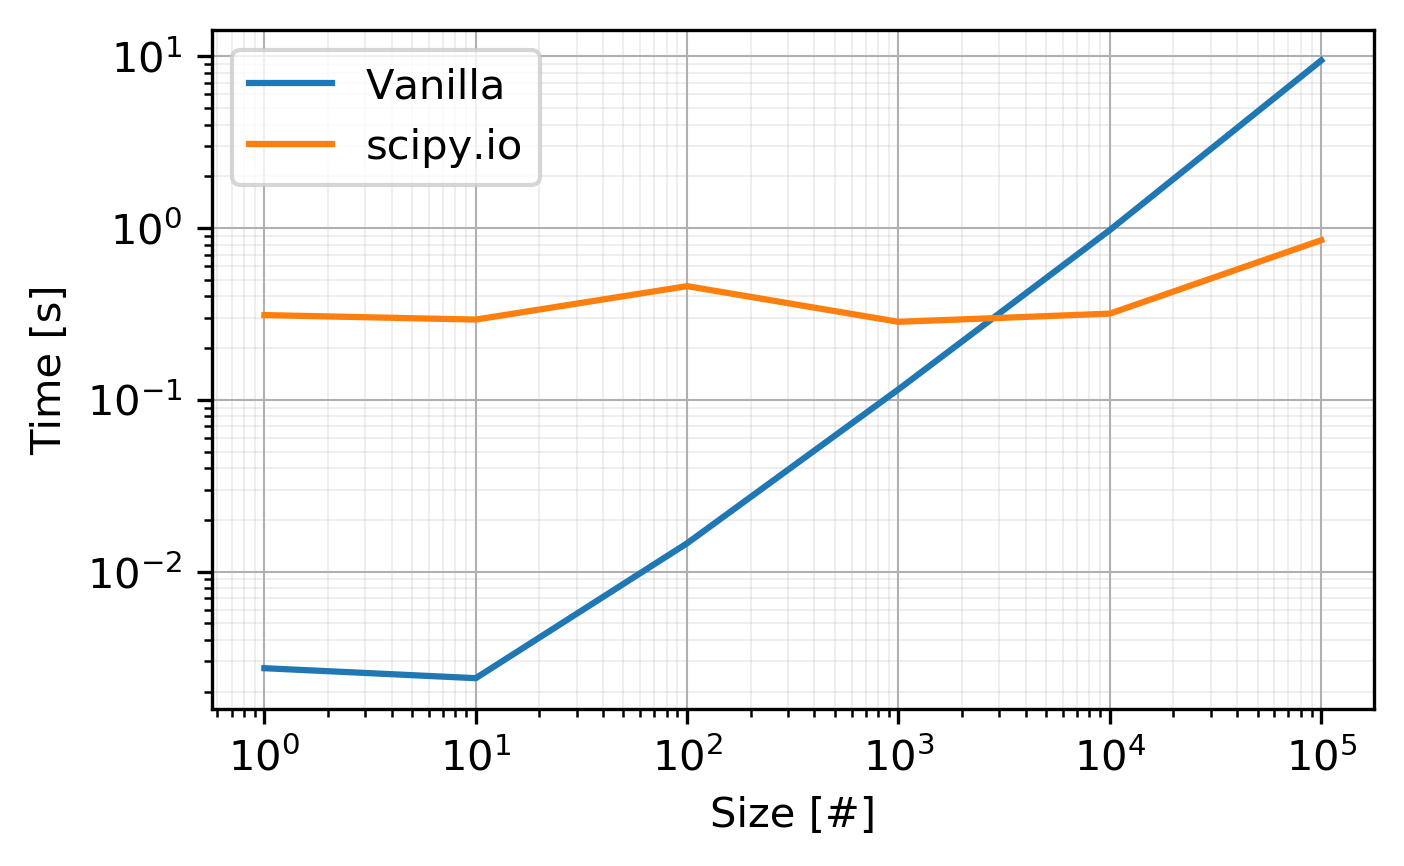

In [188]:
plt.figure(dpi=300, figsize=(5,3))
plt.ylabel("Time [s]")
plt.xlabel("Size [#]")
plt.grid(which="minor", linewidth=0.1)
plt.grid(which="major", linewidth=0.5)
plt.loglog(size, time_vanilla, label="Vanilla")
plt.loglog(size, time_scipyio, label="scipy.io")
plt.legend()
plt.show()

In conclusion, the `scipy.io` has more initial overhead, most probably due to the `io` operations. As a rule of thumb, if your array is larger than ~3000 doubles, than the faster method of conversion might be `scipy.io.savemat`.

## MATLAB datastructure into Python

Conversion from MATLAB data structures into Python can be used [easily through numpy](https://nl.mathworks.com/matlabcentral/answers/327455-convert-matlab-engine-outputs-to-numpy-arrays)

In [143]:
%%timeit

tested = np.asarray(test_from)

232 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Simulink with MATLAB Engine in Python

See [Speed Up Your Simulations with Rapid Accelerator Mode](https://nl.mathworks.com/company/newsletters/articles/speed-up-your-simulations-with-rapid-accelerator-mode.html) for original documentation. Here is the Python implementation.

Suppose we want to vary the coefficient of restitution, specified as k in the block dialog. To tune the value of k, we need to define it as a Simulink.Parameter object1:

In [86]:
import matlab.engine
eng = matlab.engine.start_matlab()

Exception ignored in: <function MatlabEngine.__del__ at 0x7f0a202bfe18>
Traceback (most recent call last):
  File "/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/matlab/engine/matlabengine.py", line 250, in __del__
    self.exit()
  File "/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/matlab/engine/matlabengine.py", line 232, in exit
    pythonengine.closeMATLAB(self.__dict__["_matlab"])
SystemError: MATLAB process cannot be terminated.


In [41]:
# k = eng.Simulink.Parameter
#k.CoderInfo.StorageClass = 'SimulinkGlobal';
#k.Value = -0.9;
# print(k)

import matlab.engine
eng = matlab.engine.start_matlab()
mdl = 'vdp';

rtp = eng.Simulink.BlockDiagram.buildRapidAcceleratorTarget(mdl);


In [27]:
res = eng.sim('vdp')

In [28]:
eng.plot(res)

In [42]:
# import matlab.engine
# eng = matlab.engine.start_matlab()
simOut = eng.sim('vdp','SimulationMode','normal','AbsTol','1e-5',
            'SaveState','on','StateSaveName','xout',
            'SaveOutput','on','OutputSaveName','yout',
 'SaveFormat', 'Dataset');



In [45]:

import numpy as np
eng.plot(np.asarray(simOut))


IndexError: index exceeds matrix dimensions

In [81]:
t1 = np.array([[1.,2.,3.,4.]])
t2 = np.array([[10.,20.,30.,40.]])
tt = np.array([0.5, 3.4, 2.1])
import matlab

x = eng.interp1(matlab.double(t1.tolist()), 
                matlab.double(t2.tolist()), 
                matlab.double(tt.tolist()))

In [82]:
import numpy as np
x = np.array(x)
print(x)

[[nan 34. 21.]]


In [53]:
simOut = eng.sim('vdp','SimulationMode','normal','AbsTol','1e-5',
            'SaveState','on','StateSaveName','xout',
            'SaveOutput','on','OutputSaveName','yout',
 'SaveFormat', 'Dataset');
# outputs = simOut.get('yout')
print(simOut.yout)

AttributeError: 'matlab.object' object has no attribute 'yout'

In [26]:
print(res.__dic__)

AttributeError: 'matlab.object' object has no attribute '__dic__'

In [29]:

eng.workspace["y"] = [1,1,2]
print(eng.workspace)

In [32]:
print(eng.workspace["y"])

[1, 1, 2]


In [37]:
dir(res.__dir__)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__text_signature__']